In [50]:
import pypsa
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.dates as mdates
from datetime import datetime
from datetime import date
from cProfile import label

%matplotlib inline
plt.rc("figure", figsize=(8, 8))

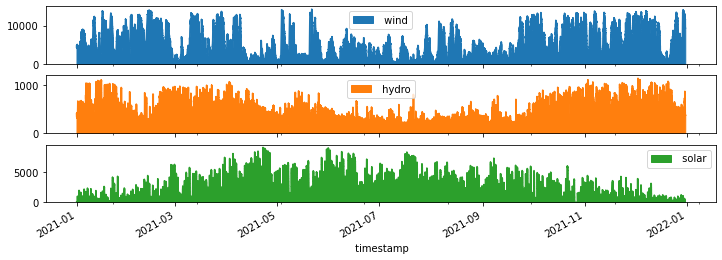

In [51]:
df = pd.read_csv (r'/home/jason/storage-diss/gridwatch.csv', index_col=1, parse_dates=True ) #year of 2021
del df['id']
axs = df.plot.area(figsize=(12, 4), subplots=True)

In [52]:
network = pypsa.Network()

In [53]:
network.snapshots = i = pd.date_range("2021-01-01 00:00", "2021-01-31 23:00", freq="1H")

network.snapshots


DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 01:00:00',
               '2021-01-01 02:00:00', '2021-01-01 03:00:00',
               '2021-01-01 04:00:00', '2021-01-01 05:00:00',
               '2021-01-01 06:00:00', '2021-01-01 07:00:00',
               '2021-01-01 08:00:00', '2021-01-01 09:00:00',
               ...
               '2021-01-31 14:00:00', '2021-01-31 15:00:00',
               '2021-01-31 16:00:00', '2021-01-31 17:00:00',
               '2021-01-31 18:00:00', '2021-01-31 19:00:00',
               '2021-01-31 20:00:00', '2021-01-31 21:00:00',
               '2021-01-31 22:00:00', '2021-01-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=744, freq='H')

In [54]:
network.add('Bus',"London", v_nom=380)
network.add("Bus", "HydrogenStore", carrier="H2")

network.buses

attribute,v_nom,type,x,y,carrier,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
London,380.0,,0.0,0.0,AC,None,1.0,0.0,inf,PQ,
HydrogenStore,1.0,,0.0,0.0,H2,None,1.0,0.0,inf,PQ,


In [55]:
#Demand
network.add(
  "Load",
  name= 'LondonDemand',
  bus='London',
  p_set= [3000]*len(network.snapshots) #MW active power set point
)

Text(0.5, 0, 'Time Stamp')

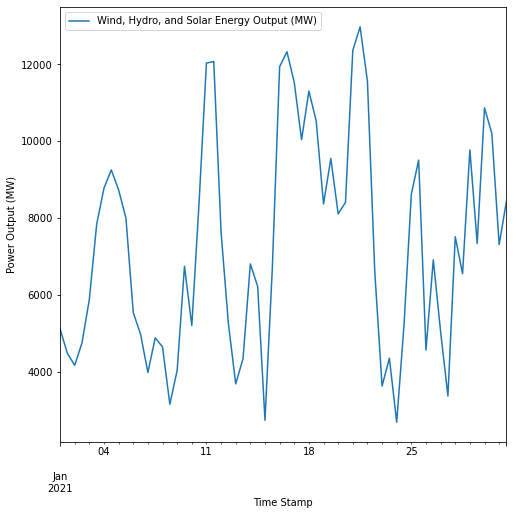

In [56]:
df = pd.read_csv (r'/home/jason/storage-diss/gridwatch.csv', index_col=1, parse_dates=True ) #year of 2021
del df['id']
#df.plot()
df = df.sum(axis = 1)
resample = df.resample('12H')
#HourlyData = resample.df
HourlyData = resample.mean()

HourlyData['2021-1-01':'2021-1-31'].plot(label='Wind, Hydro, and Solar Energy Output (MW)')
plt.legend(loc="upper left")
plt.ylabel('Power Output (MW)')
plt.xlabel('Time Stamp')

In [57]:
HourlyData['2021-1-01':'2021-1-31'].values.min()

2685.4599003680555

In [58]:
HourlyData.max() #expected to be lower when averaged

15106.991656222222

In [59]:
df = pd.read_csv (r'/home/jason/storage-diss/gridwatch.csv', index_col=1, parse_dates=True ) #year of 2021
del df['id']
#df.plot()
df = df.sum(axis = 1)
resample = df.resample('1H')
HourlyData = resample.mean()

network.add(
    'Generator',
    name= 'TotalGenerator',
    bus= 'London',
    p_nom= 19435.583333333332,#MW nominal power
    p_max_pu= HourlyData["2021-01-01 00:00": "2021-01-31 23:24"].values / HourlyData["2021-01-01 00:00": "2021-01-31 23:24"].values.max(),
    #p_nom= 32700, #MW nominal power
    #p_max_pu= df["2021-01-01 00:00": "2021-01-31 23:00"],
    capital_cost= 1600000, #currency/MWh
    efficiency=1,
    marginal_cost=95, #currency/MWh
    carrier='AC'
    )

#network.generators_t.p_set.plot()
#plt.tight_layout()

In [60]:



#Generation to storage, Electrolysers
network.add(
  "Link",
  "Electrolyser",
  bus0="London",
  bus1="HydrogenStore",
  capital_cost=350000, #currency/MWh
  p_nom_extendable=True, #Switch to allow capacity p_nom to be extended
  efficiency=0.8,
)

#H2 to London, Fue Cells
network.add(
  "Link",
  "Fuel Cell",
  bus0="HydrogenStore",
  bus1="London",
  capital_cost=339000,
  p_nom_extendable=True,
  efficiency=0.58,
)

#Storage
network.add(
  "Store",
  "Hydrogen Storage",
  bus="HydrogenStore",
  capital_cost=11200,
  marginal_cost=25, #currency/MWh
  e_nom_extendable=True,
  e_cyclic=True, #True, then e_initial is ignored and the initial energy is set to the final energy for the group of snapshots in the OPF.
)


In [61]:
network.lopf()

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using glpk
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 868360264.69587
  Upper bound: 868360264.69587
  Number of objectives: 1
  Number of constraints: 6697
  Number of variables: 3724
  Number of nonzeros: 13393
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 0
      Number of created subproblems: 0
  Error rc: 0
  Time: 0.921393632888794
# ----------------------------------------------------------
#   Solution Information
# ---------

/home/jason/anaconda3/lib/python3.9/site-packages/pypsa/opf.py:1293: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  pd.concat({c.name:


(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

In [62]:
network.objective *12 / 10**9

10.420323176350442

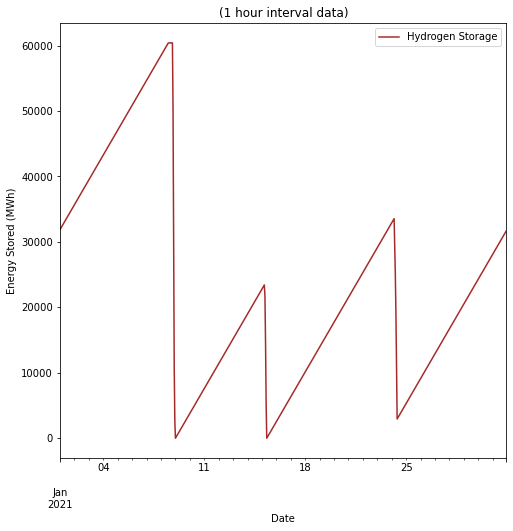

In [63]:
import matplotlib.pyplot as plt

array = network.stores_t.e * 12
array .plot(color="brown")
plt.xlabel("Date")
plt.ylabel("Energy Stored (MWh)")
plt.title("(1 hour interval data)")
plt.legend()